# IVT Reaction Optimization Analysis

In [1]:
import plotly.subplots
from skopt.sampler import Lhs
from skopt import space
from skopt.optimizer import Optimizer
import pandas as pd
import numpy as np
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from collections import namedtuple
from itertools import repeat
import json


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [23]:


runs = pd.read_csv("ivt_runs.csv")
runs.pop(runs.columns[0])


with open("ivt_params.json","r") as f:   
    param_specs = json.load(f)
    

params = runs.columns[:-2].tolist()
runs.head()


CoFactor  CoFactorC       DTT  Inhibitor      NTPs  Plasmid  Ppase  \
0      MgCl2   5.241685  9.682149       1242  3.225154       40      7   
1  MgAcetate  82.624177  2.514460       1854  4.236028       11      1   
2  MgAcetate  59.999714  7.093639        829  8.569656       61     10   
3      MgCl2  36.478188  0.181238        410  7.324906       86      3   
4  MgAcetate  98.221202  4.048452        629  3.422910       17      8   

   Spermidine     T7  Temperature  Time  Tris-Hcl       Eval  Concentration  
0    1.249586  34717           21    21  7.917090      0.000       0.136638  
1    6.337450  23062           42   119  7.480432   1272.525       0.851821  
2    2.651184   7346           43   263  6.888450  22567.260      12.819862  
3    9.472208  46600           30   159  6.549672    353.624       0.335381  
4    9.934467  22897           22   123  6.620547    459.822       0.395067

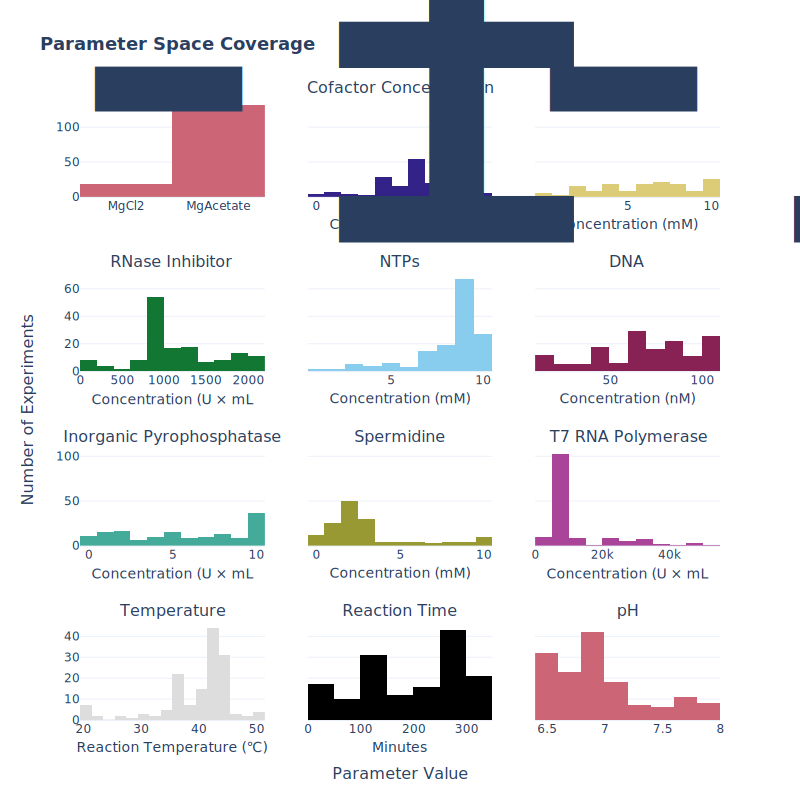

In [20]:
muted = namedtuple("Muted", "rose indigo sand green cyan wine teal olive purple pale_grey black")
muted = muted('#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
              '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD',
              '#000000')

param_name_dict = {
    "CoFactor": "Cofactor",
    "CoFactorC": "Cofactor Concentration",
    "DTT": "DTT",
    "Inhibitor": "RNase Inhibitor",
    "NTPs": "NTPs",
    "Plasmid": "DNA",
    "Ppase": "Inorganic Pyrophosphatase",
    "Spermidine": "Spermidine",
    "Tris-Hcl": "pH",
    "T7": "T7 RNA Polymerase",
    "Time": "Reaction Time",
    "Temperature": "Temperature",
    "Eval":"Eval",
    "Concentration":"Concentration"
}

param_desc_dict = {
    "CoFactor": "",
    "CoFactorC": "Concentration (mM)",
    "DTT": "Concentration (mM)",
    "Inhibitor": "Concentration (U &#xd7; mL<sup>-1</sup>)",
    "NTPs": "Concentration (mM)",
    "Plasmid": "Concentration (nM)",
    "Ppase": "Concentration (U &#xd7; mL<sup>-1</sup>)",
    "Spermidine": "Concentration (mM)",
    "Tris-Hcl": "",
    "T7": "Concentration (U &#xd7; mL<sup>-1</sup>)",
    "Time": "Minutes",
    "Temperature": "Reaction Temperature (&#8451;)"
}
nrows = 4
ncols = 3
c_param = 0

fig = make_subplots(rows=nrows, cols=ncols,
                    shared_yaxes=True,
                    y_title="Number of Experiments",
                    x_title="Parameter Value",
                    subplot_titles=[param_name_dict[param_name] for param_name in params])#)

for r in range(1, nrows+1):
    for c in range(1, ncols+1):
        next_param = params[c_param]
        c_param +=1
        x = runs[next_param]

        fig.add_trace(
            go.Histogram(
                x=x,
                name=next_param,
            )
            ,
            row=r, col=c)

        fig.update_xaxes(title=dict(text=param_desc_dict[next_param],
                                    standoff=5  #distance between axis title and axis
                                    ), row=r, col=c)

fig.update_layout(
    title=dict(text="<b>Parameter Space Coverage<b>",
               x = 0.05,
               font=dict(
                   size=18
                   )
               ),
               template="plotly_white",
               height=800,
               width=800,
               colorway=muted,
               showlegend=False)
fig.layout.annotations[-2].yshift=-40


fig.write_image(file="param_coverage.svg",format='svg',engine="kaleido")
fig.show(renderer="svg")

In [4]:
param_name_par_dict = {
    "Tris-Hcl": "pH",
    "T7": "T7",
    "Time": "Time",
    "Temperature": "Temperature",
    "Eval": "Eval"
}

cofactor_idx = pd.DataFrame({'CoFactor': runs['CoFactor'].unique()})
cofactor_idx["CoFactorIdx"] = cofactor_idx.index


evals_par = pd.merge(runs, cofactor_idx, on='CoFactor', how='left')
evals_par["CoFactor"].replace("MgAcetate","MgAc.")



fig = go.Figure(data=go.Parcoords(
    line=dict(color=evals_par["Eval"],
              colorscale="Tempo",
              showscale=True,
              cmid=2,
              cmin=0,
              cmax=max(evals_par['Eval'])
              ),
    dimensions=[
        dict(label='Cofactor', values=evals_par["CoFactorIdx"],tickvals = evals_par['CoFactorIdx'], ticktext = ["MgCl2","MgAcetate"]),
        dict(label='Cofactor Concentration', values=evals_par["CoFactorC"]),
        dict(label='DTT', values=evals_par["DTT"]),
        dict(label='Ppase', values=evals_par["Ppase"]),
        dict(label='RNase Inhibitor', values=evals_par["Inhibitor"]),
        dict(label='NTPs', values=evals_par["NTPs"]),
        dict(label='DNA', values=evals_par["Plasmid"]),
        dict(label='Spermidine', values=evals_par["Spermidine"]),
        dict(label='T7', values=evals_par["T7"]),
        dict(label='Temperature', values=evals_par["Temperature"]),
        dict(label='pH', values=evals_par["Tris-Hcl"]),
        dict(label='Time (min)', values=evals_par["Time"]),
        dict(label='Eval', values=evals_par["Eval"])
    ])
)

fig.update_layout(
    height=400,
    width=1400,
    margin=dict(l=100)
)

fig.write_image(file="par_coordinate_2.svg", format='svg', engine="kaleido")

fig.show(renderer="svg")


In [5]:
fig = go.Figure(data=go.Parcoords(
    line=dict(color=evals_par["Concentration"],
              colorscale="Tempo",
              showscale=True,
              cmid=2,
              cmin=0,
              cmax=max(evals_par['Concentration'])
              ),
    dimensions=[
        dict(label='Cofactor', values=evals_par["CoFactorIdx"],tickvals = evals_par['CoFactorIdx'], ticktext = ["MgCl2","MgAcetate"]),
        dict(label='Cofactor Concentration', values=evals_par["CoFactorC"]),
        dict(label='DTT', values=evals_par["DTT"]),
        dict(label='Ppase', values=evals_par["Ppase"]),
        dict(label='RNase Inhibitor', values=evals_par["Inhibitor"]),
        dict(label='NTPs', values=evals_par["NTPs"]),
        dict(label='DNA', values=evals_par["Plasmid"]),
        dict(label='Spermidine', values=evals_par["Spermidine"]),
        dict(label='T7', values=evals_par["T7"]),
        dict(label='Temperature', values=evals_par["Temperature"]),
        dict(label='pH', values=evals_par["Tris-Hcl"]),
        dict(label='Time (min)', values=evals_par["Time"]),
        dict(label='mRNA Concentration', values=evals_par["Concentration"])
    ])
)

fig.update_layout(
    height=400,
    width=1400,
    margin=dict(l=100)
)

fig.write_image(file="par_coordinate_concentration.svg", format='svg', engine="kaleido")

fig.show(renderer="svg")

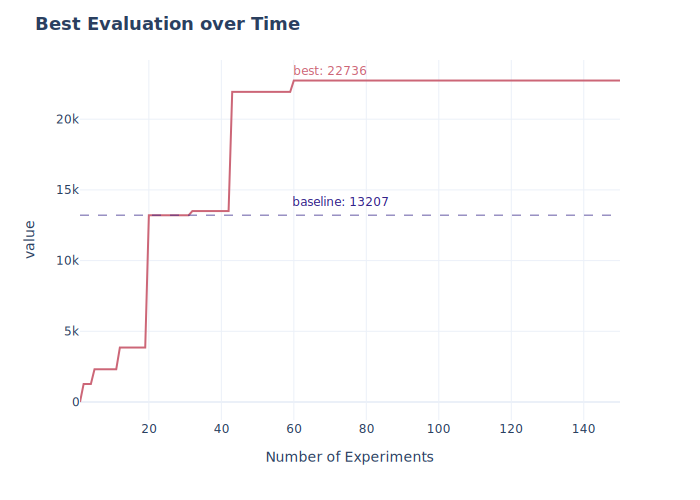

In [4]:
eval_progress = runs["Eval"].drop(index=2)
x = []
y = []
avg_eval = []
for i in range(1, len(runs) + 1):
    x.append(i)
    y.append(eval_progress.head(i).max())
    avg_eval.append((eval_progress.head(i).tail(min(i, 5)).mean()))

progress = px.line(
    x=x,
    y=[y],
    labels={
        "x": "Number of Experiments",
        "y": "Best Evaluation Found",
    },
    color_discrete_sequence=muted

)
progress.add_hline(y=13207, line_width=1.5, line_dash="dash", line_color=muted[1], opacity=0.5)

progress.add_annotation(
    x=x[72], y=y[39],
    text=f"baseline: {13207}",
    font=dict(color=muted[1]),
    showarrow=False,
    yshift=10
)

progress.update_layout(title=dict(text="<b>Best Evaluation over Time<b>",
                                  x=0.05,
                                  font=dict(
                                      size=18
                                  )
                                  ), template="plotly_white",
                       showlegend=False)

progress.add_annotation(
    x=x[69], y=y[69],
    text=f"best: {round(y[69])}",
    font=dict(color=muted[0]),
    showarrow=False,
    yshift=10
)

progress.write_image(file="progress.svg", format='svg', engine="kaleido")
progress.show(renderer="svg")

### Gradient Boosted Tree Model for feature importance

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import clone
from sklearn.model_selection import cross_validate, LeaveOneOut

x = runs.loc[:, ~runs.columns.isin(['Eval','Concentration'])]

# encode categorical attributes with one-hot encoding
cat_attribs = ['CoFactor']
one_hot = ColumnTransformer([('CoFactor',
                              OneHotEncoder(handle_unknown='ignore'),
                              cat_attribs)], remainder='passthrough')
encoder = one_hot.fit(x)
x: np.ndarray = encoder.transform(x)

y = runs['Eval']
y: np.ndarray = y.to_numpy()

var_names = runs['CoFactor'].unique().tolist() + list(runs)[1:-2] # this was for experiment 1
var_names = np.array(var_names)

In [8]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=50)
model = xgb.fit(x, y)

In [9]:
est = XGBRegressor(n_estimators=50,tree_method="gpu_hist")
xgb_scores = cross_validate(est, x, y, n_jobs=-1, scoring=("neg_mean_squared_error","explained_variance","neg_mean_absolute_error"),cv=LeaveOneOut())

xgb_scores = pd.DataFrame(xgb_scores)
xgb_scores.head()

fit_time  score_time  test_neg_mean_squared_error  test_explained_variance  \
0  3.493000    0.005828                -1.497044e+07                      1.0   
1  1.317212    0.042854                -3.030812e+05                      1.0   
2  3.331471    0.016511                -5.831584e+02                      1.0   
3  3.364663    0.006611                -1.024733e+05                      1.0   
4  3.658331    0.024413                -4.004074e+04                      1.0   

   test_neg_mean_absolute_error  
0                  -3869.165283  
1                   -550.528113  
2                    -24.148672  
3                   -320.114525  
4                   -200.101828

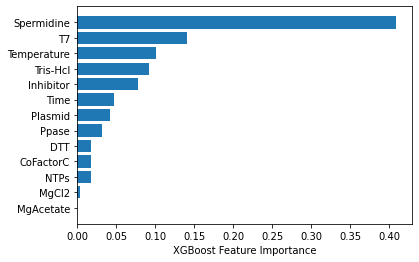

In [11]:
from matplotlib import pyplot as plt
sorted_idx = xgb.feature_importances_.argsort()
sorted_idx = list(sorted_idx)
plt.barh(var_names[sorted_idx],xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.savefig("xgboost_feature_importance.svg",format="svg")

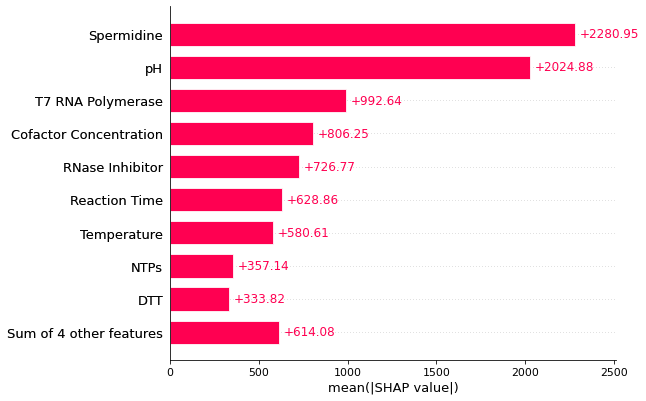

In [12]:
param_name_dict["MgCl2"] = "MgCl2"
param_name_dict["MgAcetate"] = "MgAcetate"


import shap
explainer = shap.TreeExplainer(model)
explainer.data_feature_names = [param_name_dict[var_name] for var_name in var_names]
shap_values = explainer(x, check_additivity=False)
bar = shap.plots.bar(shap_values,show=False)
plt.savefig("shap_bar.svg", format="svg", bbox_inches="tight")

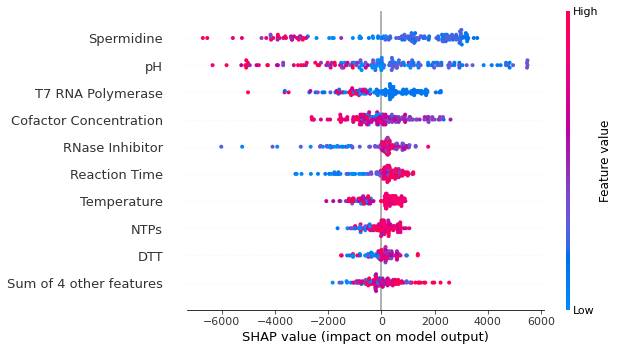

In [13]:
shap.plots.beeswarm(shap_values,show=False)
plt.savefig("shap_beeswarm.svg", format="svg", bbox_inches="tight")

### Model Comparison

#### Distribution of Evaluations

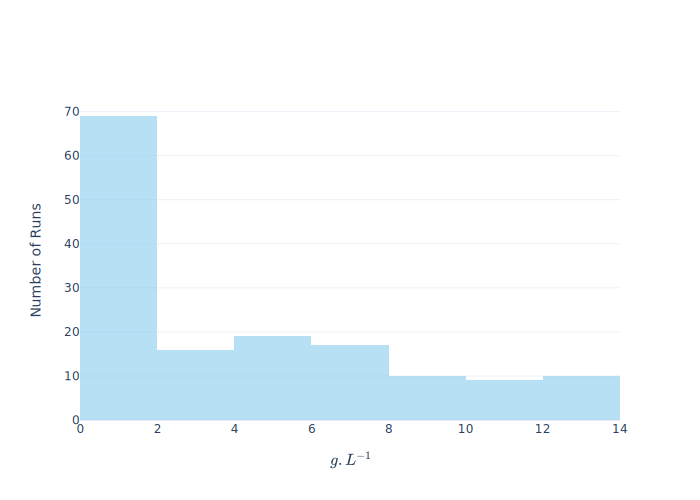

In [14]:
y = runs['Concentration']
fig = go.Figure()
fig.add_trace(go.Histogram(x=y, name="Experiment Evaluations", histnorm="",marker_color=muted[4],opacity=0.6))
fig.update_layout(template="plotly_white",yaxis_title="Number of Runs", xaxis_title="mRNA ($g.L^{-1}$)")
fig.write_image(file="eval.svg", format='svg', engine="kaleido")
fig.show(renderer="svg")


In [15]:
def as_dimension(params):
    """ Converts a parameter space to a list of `Dimension` objects that can be used with
    a scikit-optimize Optimizer.

    [Dimension](https://scikit-optimize.github.io/stable/modules/generated/skopt.space.space.Dimension.html?highlight=dimension#skopt.space.space.Dimension)

    returns:
        `List[skopt.space.space.Dimension]`: list of `Dimension` objects
   """
    dimensions = []
    for param in params:
        if param["dtype"] == "int":
            dimensions.append(space.Integer(param["low"], param["high"], name=param["name"]))
        elif param["dtype"] == "float":
            dimensions.append(space.Real(param["low"], param["high"], name=param["name"]))
        elif param["dtype"] == "categorical":
            dimensions.append(space.Categorical(
                param["categories"], transform="onehot", name=param["name"]))
    return dimensions

In [24]:
from sklearn import preprocessing
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern, RBF, WhiteKernel
import json

x = runs.loc[:, ~runs.columns.isin(['Eval','Concentration'])]

y = runs['Eval']
y: np.ndarray = y.to_numpy()
y = y.tolist()


dims = as_dimension(param_specs)


optimizer = Optimizer(dimensions=dims,
                      base_estimator="gp",
                      acq_func="gp_hedge", 
                      acq_optimizer="auto",
                      n_initial_points=1,
                      initial_point_generator="lhs")


x = x.values.tolist()

x_ = optimizer.space.transform(x)

est = GaussianProcessRegressor(n_restarts_optimizer=2,
                               normalize_y=True,
                               kernel= 1**2 * Matern(length_scale=[1.0]*12,
                                                     nu=0.5)
                                      +WhiteKernel(noise_level=1.0),
                               noise="gaussian"
                               )
gp_scores = cross_validate(est, x_, y,n_jobs=-1,scoring=("neg_mean_squared_error","explained_variance","neg_mean_absolute_error"),cv=LeaveOneOut())
gp_scores = pd.DataFrame(gp_scores)

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound a

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound a

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 8 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound a

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calli

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound a

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound a

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound a

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound a

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 9 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound a

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound a

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound a

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound a

/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/davex32/.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound a

In [25]:
import shap
from matplotlib import pyplot as plt

est = GaussianProcessRegressor(n_restarts_optimizer=2,
                               normalize_y=True,
                               kernel= 1**2 * Matern(length_scale=[1.0]*12,
                                                     nu=0.5)
                                      +WhiteKernel(noise_level=1.0),
                               noise="gaussian"
                               )
fit_est:GaussianProcessRegressor = est.fit(x_,y)

f = lambda x:fit_est.predict(x)


explainer = shap.Explainer(f, x_.mean(axis=0).reshape(1,x_.shape[1]),feature_names=[param_name_dict[param_name] for param_name in params])

print(explainer)
shap_values = explainer(x_)
shap.plots.beeswarm(shap_values,show=False)
plt.savefig("feature_importance_gp.svg",format="svg", bbox_inches="tight")


shap.explainers.Permutation()


UnsupportedError: Failed in object mode pipeline (step: analyzing bytecode)
Use of unsupported opcode (IS_OP) found

File "../../../.cache/pypoetry/virtualenvs/ivt-VYzcq6ov-py3.9/lib/python3.9/site-packages/shap/utils/_masked_model.py", line 377:
def _build_fixed_single_output(averaged_outs, last_outs, outputs, batch_positions, varying_rows, num_varying_rows, link, linearizing_weights):
    <source elided>
                last_outs[varying_rows[i]] = outputs[batch_positions[i]:batch_positions[i+1]]
            if linearizing_weights is not None:
            ^


### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

x = runs.loc[:, ~runs.columns.isin(['Eval','Concentration'])]

# encode categorical attributes with one-hot encoding
cat_attribs = ['CoFactor']
one_hot = ColumnTransformer([('CoFactor',
                              OneHotEncoder(handle_unknown='ignore'),
                              cat_attribs)], remainder='passthrough')
encoder = one_hot.fit(x)
x: np.ndarray = encoder.transform(x)

y = evals['Eval']
y: np.ndarray = y.to_numpy()

est = RandomForestRegressor(n_estimators=50)
rf_scores = cross_validate(est, x, y,n_jobs=-1, scoring=("neg_mean_squared_error","explained_variance","neg_mean_absolute_error"),cv=LeaveOneOut())
rf_scores = pd.DataFrame(rf_scores)
rf_scores.head()

## Comparing the models

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=-gp_scores["test_neg_mean_absolute_error"], name="GP"))
fig.add_trace(go.Box(y=-rf_scores["test_neg_mean_absolute_error"], name="RF"))
fig.add_trace(go.Box(y=-xgb_scores["test_neg_mean_absolute_error"], name="XGB"))
fig.update_traces(boxpoints='all', jitter=0.1)
fig.update_layout(template="plotly_white",
                yaxis_title="Absolute Prediction Error ",
                  colorway=muted,
                  showlegend=False)
fig.write_image(file="compare_estimators.svg", format='svg', engine="kaleido")
fig.show()
